# DSCI 552 | Homework 2 - Combined Cycle Power Plant Data Set

| Key             | Value           |
| --------------- | --------------- |
| Submitted By    | Ruchit Bhardwaj |
| USC ID          | 1111-4177-99    |
| Github Username | ruch0401        |


The dataset contains data points collected from a Combined Cycle Power Plant over
6 years (2006-2011), when the power plant was set to work with full load. Features
consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP),
Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical
energy output (EP) of the plant.

### (a) Download the Combined Cycle Power Plant data: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

In [1]:
# performing all imports and installing prettytable during execution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### NOTE  
Please note that for printing the outputs in a tabular manner (so that the answer is easily understood by the instructors, I have made use of the prettytable external library.
It is possible that this might not be available on the instructor machines.
To avoid that, I have made sure to explicitly add an installation command.

This should automatically install prettytable and import it correctly.

In [2]:
COLUMN_NAMES = ["AT", "V", "AP", "RH", "PE"]
PATH = '../data/CCPP/Folds5x2_pp.xlsx'


# reading data from csv and creating dataframe
df = pd.read_excel(PATH)
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


### (b) Exploring the data

#### (i) How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
row_count = df.shape[0]
col_count = df.shape[1]
hh = ["Rows #", "Columns #"]
rr = [[row_count, col_count]]
pd.DataFrame(data=rr, columns=["Rows", "Columns"])

,Rows,Columns
0,9568,5


##### Information about the dataset $^{[1]}$

- The dataset contains 9568 data points collected from a Combined Cycle Power Plant.
- Features are
    - Ambient Temperature (AT)
    - Vacuum (V)
    - Ambient Pressure (AP)
    - Relative Humidity (RH)
- It predicts the hourly energy output of the plant (Energy Output (EP))

#### (ii) Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

Text(0.5, 1, 'Scatter Plot of all independent variables')

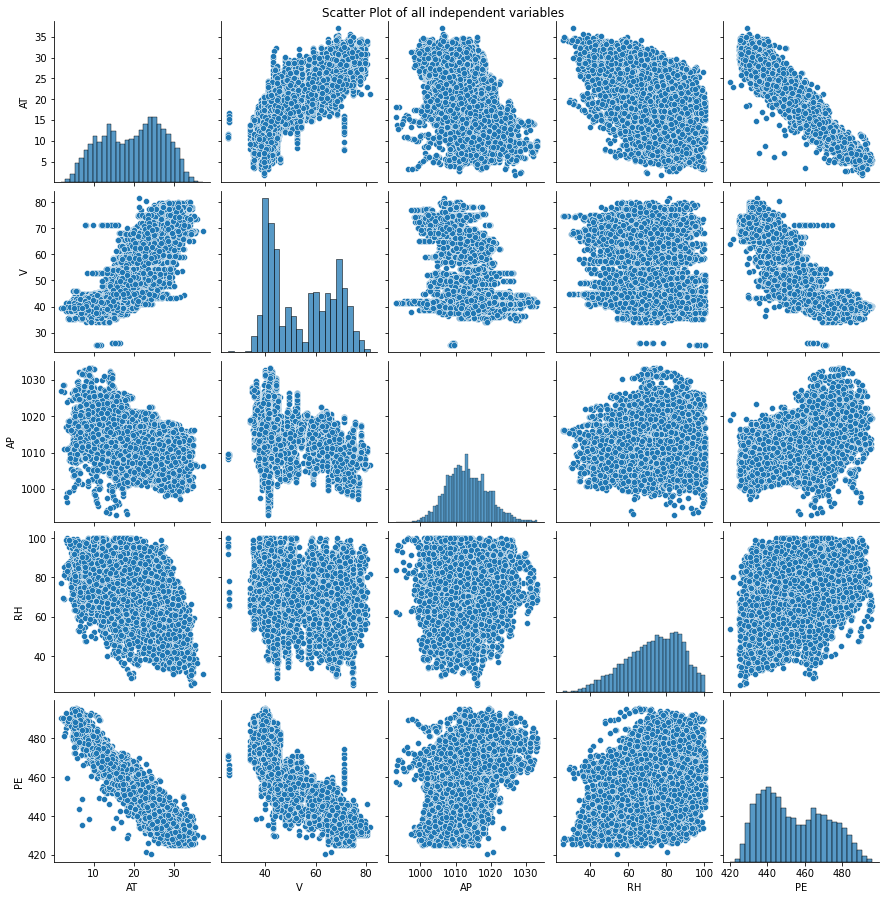

In [4]:
# initializing and defining scatterplot
fig = sns.pairplot(data = df)
fig.fig.suptitle("Scatter Plot of all independent variables", y=1)

##### Findings of the dataset

In terms of the correlation of the dataset - 
- AT is positively correlated with V
- AT is negatively correlated with PE
- V is negatively correlated with PE

#### (iii) What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table

In [5]:
summary = {}
mean_list = []
median_list = []
range_list = []
first_q_list = []
third_q_list = []
inter_q_list = []
for col in df.columns:
    mean_list.append(round(np.mean(df[col]), 2))
    median_list.append(round(np.median(df[col]), 2))
    range_list.append(round(np.max(df[col]) - np.min(df[col]), 2))
    fq = np.quantile(df[col], 0.25)
    tq = np.quantile(df[col], 0.75)
    first_q_list.append(round(fq, 2))
    third_q_list.append(round(tq, 2))
    inter_q_list.append(round(tq - fq, 2))

summary = {
    "Variable": df.columns,
    "Mean": mean_list,
    "Median": median_list,
    "Range": range_list,
    "First Quartile": first_q_list,
    "Third Quartile": third_q_list,
    "Interquartile Range": inter_q_list
}

pd.DataFrame(summary)

,Variable,Mean,Median,Range,First Quartile,Third Quartile,Interquartile Range
0,AT,19.65,20.34,35.30,13.51,25.72,12.21
1,V,54.31,52.08,56.20,41.74,66.54,24.80
2,AP,1013.26,1012.94,40.41,1009.10,1017.26,8.16
3,RH,73.31,74.97,74.60,63.33,84.83,21.50
4,PE,454.37,451.55,75.50,439.75,468.43,28.68


#### 1(c). For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [6]:
def fit_model(x, y, x_constant, col_name):
    model = sm.OLS(y, x_constant).fit()
    print(model.summary())
    return model

def get_outlier_indices(model):
    THRESHOLD = 4 / len(df)
    influence = model.get_influence()
    cooks = influence.cooks_distance
    outliers_idx = np.where(cooks[0] > THRESHOLD)
    return outliers_idx

coefficients = {}
def fit_model_and_summarize(col_name):
    print(f"\n\nSummarizing Regression fit for predictor_value = {col_name}")
    if (col_name != "PE"):
        y = df["PE"].to_numpy()
        x = df[col_name].to_numpy()
        x_constant = sm.add_constant(x, prepend=False)
        model = fit_model(x, y, x_constant, col_name)
        outlier_indices = get_outlier_indices(model)
        coefficients[col_name] = model.params
        fig, axes = plt.subplots(figsize=(12, 7))
        with plt.style.context('ggplot'):
            axes.scatter(x, y, alpha=0.3, label="Data point")
            axes.scatter(x[outlier_indices], y[outlier_indices], marker="+", label="Outliers")
            axes.plot(x, model.predict(x_constant), "tab:red", label="Regression Result")
        axes.set_title(f"Simple Linear Regression for {col_name}")
        axes.set_xlabel(col_name)
        axes.set_ylabel("PE")
        axes.legend()
        plt.show()

        outliers_tuple = np.vstack((x[outlier_indices], y[outlier_indices]))
        return pd.DataFrame(outliers_tuple)



Summarizing Regression fit for predictor_value = AT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:39   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

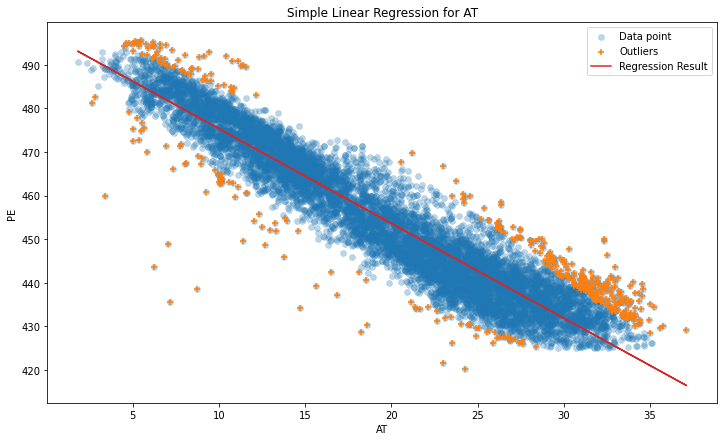

        AT      PE
0     5.41  495.24
1    29.01  446.22
2    32.72  437.99
3    35.56  429.69
4    27.54  450.22
..     ...     ...
411  33.20  438.12
412  30.26  442.98
413  34.03  440.29
414   5.01  475.34
415  26.22  454.20

[416 rows x 2 columns]


In [7]:
outlier_AT = fit_model_and_summarize("AT")
temp = outlier_AT.T
temp.columns = ["AT", "PE"]
if outlier_AT.empty:
    print("No outliers present!")
else:
    print(temp)



Summarizing Regression fit for predictor_value = V
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:39   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

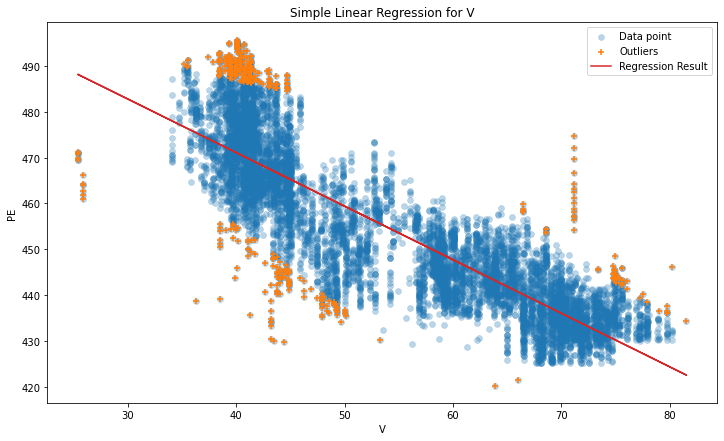

         V      PE
0    39.40  488.56
1    40.07  495.24
2    48.60  436.06
3    43.43  448.06
4    39.33  491.49
..     ...     ...
418  75.23  443.78
419  39.72  455.58
420  44.89  445.45
421  43.77  446.05
422  25.36  470.90

[423 rows x 2 columns]


In [8]:
outlier_V = fit_model_and_summarize("V")
temp = outlier_V.T
temp.columns = ["V", "PE"]
if outlier_V.empty:
    print("No outliers present!")
else:
    print(temp)



Summarizing Regression fit for predictor_value = AP
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

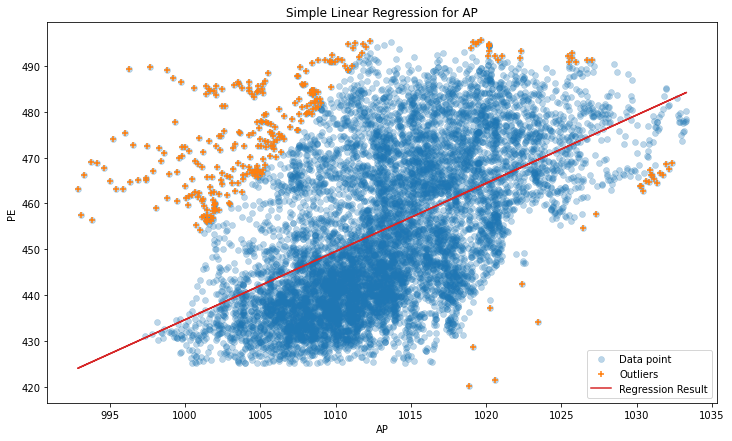

          AP      PE
0    1019.16  495.24
1    1008.52  483.80
2    1010.18  491.49
3    1008.82  481.09
4    1001.24  459.36
..       ...     ...
295  1030.61  464.95
296  1008.43  484.75
297  1005.24  479.22
298   998.27  472.16
299  1003.69  475.34

[300 rows x 2 columns]


In [9]:
outlier_AP = fit_model_and_summarize("AP")
temp = outlier_AP.T
temp.columns = ["AP", "PE"]
if outlier_AP.empty:
    print("No outliers present!")
else:
    print(temp)



Summarizing Regression fit for predictor_value = RH
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

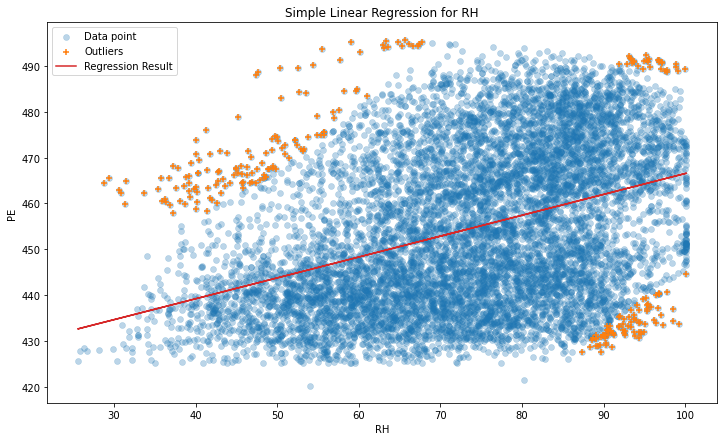

        RH      PE
0    41.25  475.98
1    43.08  462.19
2    48.84  467.54
3    64.77  495.24
4    50.00  474.60
..     ...     ...
244  97.21  490.68
245  98.84  490.50
246  90.20  430.55
247  93.39  434.11
248  99.27  433.62

[249 rows x 2 columns]


In [10]:
outlier_RH = fit_model_and_summarize("RH")
temp = outlier_RH.T
temp.columns = ["RH", "PE"]
if outlier_RH.empty:
    print("No outliers present!")
else:
    print(temp)

#### 1(d). Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$

In [11]:
all_training_data = df.iloc[:, 0:len(df.columns) - 1]
all_training_data = sm.add_constant(all_training_data.to_numpy(), prepend=False)

model_all_feature_regression = sm.OLS(df["PE"].to_numpy(), all_training_data)
model_all_feature_regression = model_all_feature_regression.fit()

print(model_all_feature_regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9775      0.015   -129.342      0.0

The null hypothesis can be rejected for all the predictors since for all of them, the p-value is 0

#### 1(e). How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

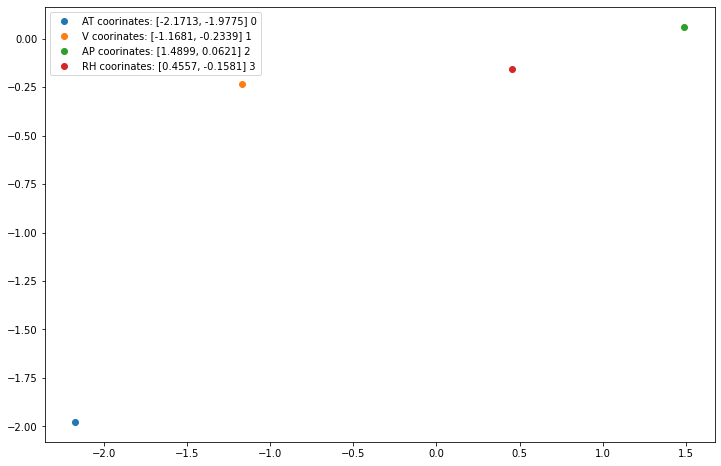

In [12]:
fig, axes = plt.subplots(figsize=(12, 8))
for i, col in enumerate(df.columns[0:len(df.columns) - 1]):
    text = f"{col} coorinates: [{round(coefficients[col][0], 4)}, {round(model_all_feature_regression.params[i], 4)}] " + str(i)
    axes.scatter(coefficients[col][0], model_all_feature_regression.params[i], label=text)
axes.legend()
plt.show()

#### 1(f). Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor $X$, fit a model of the form

$Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$

In [13]:
DEGREE = 3

def identify_non_linear_association(feature_name):
    poly = PolynomialFeatures(DEGREE)
    trainingX_poly = poly.fit_transform(df[feature_name].to_numpy().reshape(-1, 1))
    model = sm.OLS(df["PE"].to_numpy(), trainingX_poly).fit()
    print(model.summary())


In [14]:
print("\n\nFor feature: AT")
identify_non_linear_association("AT")

print("\n\nFor feature: V")
identify_non_linear_association("V")

print("\n\nFor feature: AP")
identify_non_linear_association("AP")

print("\n\nFor feature: RH")
identify_non_linear_association("RH")



For feature: AT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673  

#### Observations

- For features AT, AP and RH, the p-value is very small and hence, we can reject the null hypothesis which means that that there is evidence of non-linear association between the predictors and the response.

- However, for predictor V, the p-value for $x^2$ and $x^3$ is not negligible and for $x^2$ especially, it is of significant amount. Hence, we cannot reject the null hypothesis and hence there is no non-linear association between the predictors and the response.

#### 1(g). Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant

In [15]:
interaction_terms = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
model = smf.ols(formula = interaction_terms, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

#### Observations:

Statistical significance depends inversely on the p-value. For different p-values present in the output, the summarization of the results are as follows - 
- Considering p = 0.05, $V, AP, RH, AT:V, AT:RH, V:AP, AP:RH$ are statistically significant
- Considering p = 0.10, $AT, V:RH$ are statistically significant
- AT:AP have very large p-values and are not statistically significant

#### 1(h). Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [16]:
error_summary = {}

In [17]:
idx = [x for x in range(0,9568)]
random.seed(9568)
random.shuffle(idx)

size = math.floor(len(df) * 0.7)
train_70 = df.iloc[idx[:size], :]
test_30 = df.iloc[idx[size:], :]

tts_df_x = df.iloc[:,:-1]
tts_df_y = tts_df_y = df.iloc[:, -1:]
train_70_x, test_30_x, train_70_y, test_30_y = train_test_split(tts_df_x, tts_df_y, train_size=0.7, random_state=1)
print(df.shape)
print(train_70.shape)
print(train_70.shape)
print(train_70_x.shape)
print(test_30_x.shape)
print(train_70_y.shape)
print(test_30.shape)

# df.sample(frac=1)
# size = math.ceil(len(df) * 0.7)
# train_70 = df.iloc[idx[:size], :]
# test_30 = df.iloc[idx[size:], :]

# train_70_x = train_70.iloc[:, 0:len(train_70.columns) - 1]
# train_70_y = train_70.iloc[:, -1]
# test_30_x = test_30.iloc[:, 0:len(test_30.columns) - 1]
# test_30_y = test_30.iloc[:, -1]

(9568, 5)
(6697, 5)
(6697, 5)
(6697, 4)
(2871, 4)
(6697, 1)
(2871, 5)


In [18]:
def train(mode, formula):
    model = smf.ols(formula, train_70).fit()
    print(model.summary())
    predict_train_Y = model.predict(train_70_x)
    predict_test_Y = model.predict(test_30_x)
    train_mse = mean_squared_error(train_70_y, predict_train_Y)
    test_mse = mean_squared_error(test_30_y, predict_test_Y)
    
    o = {
        "formula_used": formula,
        "train_mse": round(train_mse, 4),
        "test_mse": round(test_mse, 4)
    }
    
    error_summary[mode] = [train_mse, test_mse]
    
    return pd.DataFrame(data=o.items(), columns=['key', 'value'])


In [19]:
FORMULA_1 = "PE ~ AT + V + AP + RH"
train("all_predictors_linear_regression", FORMULA_1)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -19620.
No. Observations:                6697   AIC:                         3.925e+04
Df Residuals:                    6692   BIC:                         3.928e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    446.0925     11.663     38.248      0.0

,key,value
0,formula_used,PE ~ AT + V + AP + RH
1,train_mse,20.7733
2,test_mse,20.7629


In [20]:
FORMULA_2 = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
train("inter_quad_terms_linear_regression", FORMULA_2)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7171.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -19158.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6396.8126   1454.860     

,key,value
0,formula_used,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,train_mse,18.0805
2,test_mse,18.1893


Based on the regression result above, we cannot reject the Null Hypothesis of $AT$, $V$, $V^2$, $AT:AP$, $V:AP$ and $V:RH$. Thus, we will only remove the 2-order terms. Although $AT$ and $V$ have large p-value as well, removing basic predictors will violate the hierachical priciple when the $AT:V$ is included.

For every run, the data is shuffled to splitting into training data and testing data. Hence, the output is likely going to vary for every run. Generally, AT has had p-value > 0.05 and sometimes not.

In [21]:
FORMULA_3 = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH'
train("remove_insignificant_predictors_linear_regression", FORMULA_3)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:38:40   Log-Likelihood:                -19168.
No. Observations:                6697   AIC:                         3.836e+04
Df Residuals:                    6686   BIC:                         3.843e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.025e+04   1096.856     

,key,value
0,formula_used,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,train_mse,18.1043
2,test_mse,18.2446


#### 1(i). KNN Regression:

##### i. Perform $k$-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of $k \in {1,2,..., 100}$ that gives you the best fit. Plot the train and test errors in terms of $1/k$


In [22]:
def performKNN(mode):
    k_rev = []
    train_error = []
    test_error = []
    min_index = 0

    if mode == "NORMALIZED":
        print("NORMALIZED Mode Selected")
        scaler = MinMaxScaler()
        train_70_x_knn = scaler.fit_transform(train_70_x)
        test_30_x_knn = scaler.fit_transform(test_30_x)
    else:
        print("RAW Mode Selected")
        train_70_x_knn = train_70_x
        test_30_x_knn = test_30_x
        
    for k in range(1, 101):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_70_x_knn, train_70_y)
        k_rev.append(1 / k)
        train_predict = knn.predict(train_70_x_knn)
        test_predict = knn.predict(test_30_x_knn)
        train_mse = mean_squared_error(train_70_y, train_predict)
        test_mse = mean_squared_error(test_30_y, test_predict)
        train_error.append(train_mse)
        test_error.append(test_mse)
        if test_mse < test_error[min_index]:
            min_index = k - 1;
            
    error_summary[mode] = [train_error[min_index], test_error[min_index]]
    summary = {
        "mode": mode,
        "train_error": round(train_error[min_index], 4),
        "test_error": round(test_error[min_index], 4),
        "k_rev": k_rev,
        "k": round((1 / k_rev[min_index]), 4)
    }
    
    attributes = {
        "k_rev": k_rev,
        "train_error": train_error,
        "test_error": test_error,
        "error_summary": error_summary
    }
    
    return [summary, attributes]

def plot_graph(k_rev, train_error, test_error):
    plt.plot(k_rev, train_error, label="Train Mean Squared Error")
    plt.plot(k_rev, test_error, label="Test Mean Squared Error")
    plt.gca().set_xlabel("1/k")
    plt.gca().set_ylabel("Mean Squared Error")
    plt.gca().legend()
    plt.show()

In [23]:
[info, attr] = performKNN("RAW")
info_temp = {
    "mode": info["mode"],
    "k": info["k"],
    "train_error": info["train_error"],
    "test_error": info["test_error"]
}
pd.DataFrame(info_temp.items())

RAW Mode Selected


,0,1
0,mode,RAW
1,k,5.0
2,train_error,10.553
3,test_error,15.7048


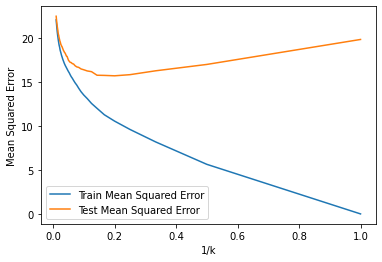

In [24]:
plot_graph(attr["k_rev"], attr["train_error"], attr["test_error"])

In [25]:
[info, attr] = performKNN("NORMALIZED")
info_temp = {
    "mode": info["mode"],
    "k": info["k"],
    "train_error": info["train_error"],
    "test_error": info["test_error"]
}
pd.DataFrame(info_temp.items())

NORMALIZED Mode Selected


,0,1
0,mode,NORMALIZED
1,k,7.0
2,train_error,11.0119
3,test_error,14.9106


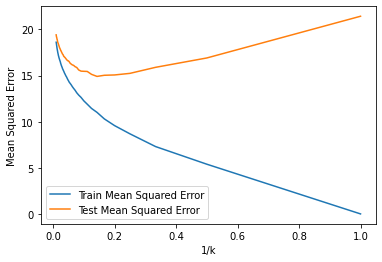

In [26]:
plot_graph(attr["k_rev"], attr["train_error"], attr["test_error"])

#### 1(j). Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

In [27]:
map_temp = {}
for key, value in attr["error_summary"].items():
    map_temp[key] = [round(elem, 4) for elem in value]

map_temp
pd.DataFrame(data=map_temp.items(), columns=["Mode", "[Train Error, Test Error]"])

,Mode,"[Train Error, Test Error]"
0,all_predictors_linear_regression,"[20.7733, 20.7629]"
1,inter_quad_terms_linear_regression,"[18.0805, 18.1893]"
2,remove_insignificant_predictors_linear_regression,"[18.1043, 18.2446]"
3,RAW,"[10.553, 15.7048]"
4,NORMALIZED,"[11.0119, 14.9106]"


> KNN is better than Linear Regression. Reason can be the non-linear nature of data. And hence, KNN performed better than LR

# 2. ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predictors p is small.
- Large sample size along with small number of predictors can cause the model to underfit if the model is an inflexible statistical learning method. Hence, a flexible model will perform better than an inflexible model.

(b) The number of predictors p is extremely large, and the number of observations n is small.
- Small sample size along with large number of predictors will cause a flexible model to overfit. Hence, a flexible model will perform worse than an inflexible model.

(c) The relationship between the predictors and response is highly non-linear.
- An inflexible model will not be able to adjust to the variances of a highly non-linear model and hence, a flexible model will perform better than a non-flexible model in this case.

(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.
- High variance = More noise which means that a flexible model will overfit. Overfitting is a bad thing and hence, here, a flexible statistical model will perform worse as compared to an inflexible model.




# 3. ISLR: 2.4.7

The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.

(a) Compute the Euclidean distance between each observation and the test point, $X1 = X2 = X3 =0$.

| Obs             | $X_1$           |$X_2$|$X_3$|$Y$|
| -- | -- |-- |--|--|
| 1 | 0 | 3 | 0 | Red |
| 2 | 2 | 0 | 0 | Red |
| 3 | 0 | 1 | 3 | Red |
| 4 | 0 | 1 | 2 | Green |
| 5 | -1 | 0 | 1 | Green |
| 6 | 1 | 1 | 1 | Red |




We know, that between any 2 points in an n-dimensional space, the euclidean distance can be denoted by -

$ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } $

In [28]:
X = [[0,3,0], [2,0,0], [0,1,3], [0,1,2], [-1,0,1], [1,1,1]]
testpoint = [[0,0,0]]
euclidean_distance_result = euclidean_distances(X, testpoint)
pd.DataFrame(euclidean_distance_result, index=[1,2,3,4,5,6], columns=[f"euclidean_distance of $Obs_i$ from testpoint"])

,euclidean_distance of $Obs_i$ from testpoint
1,3.000000
2,2.000000
3,3.162278
4,2.236068
5,1.414214
6,1.732051


(b) What is our prediction with $𝐾=1$ ? Why?
- For $K=1$, we predict that the output would be Observation number 5 as it is the closest to the test point and k = 1. So effectively, the prediction of Y is green.

(c) What is our prediction with $K = 3$? Why?
- For $K=3$, we predict that the output would be Observation numbers 2 (Red), 5 (Green) and 6 (Red). Since the majority is 3 Green vs 1 Red, we predict that the output is going to be Red

(d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?
- The value of K is inversely proportional to the flexibility of the module. As K increases, a more linear boundary is achieved. Since the question states that the decision boundary of the problem is highly non-linear, the value of K would this be small.

### References

1. [https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)